In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
path = '/content/drive/My Drive/'
path_dataset = os.path.join(path, "dataset")

In [ ]:
import pandas as pd
path_no1 = os.path.join(path_dataset, 'russian_names.csv')
names_df = pd.read_csv(path_no1,sep=';')

In [ ]:
names=names_df['Name'].str.lower().tolist()
len(names)

51529

In [ ]:
import pandas as pd
path_no1 = os.path.join(path_dataset, 'russian_surnames.csv')
surnames_df = pd.read_csv(path_no1,sep=';')

In [ ]:
category_lines = {}
all_categories = ['name','surname','word']

In [ ]:
surnames=surnames_df['Surname'].str.lower().tolist()
category_lines['surname'] = surnames
category_lines['name'] = names
len(surnames)

318474

In [ ]:
fnames=names+surnames

In [ ]:
len(fnames)

370003

In [ ]:
import json
path_no1 = os.path.join(path_dataset, 'words.json')
with open(path_no1) as json_file:
    data = json.load(json_file)

In [ ]:
len(data)

106057

In [ ]:
category_lines['word'] = data

In [ ]:
import torch
all_letters={' ':0, 'а':1,'б':2,'в':3,'г':4,'д':5,'е':6,'ё':7,'ж':8,'з':9,'и':10,'й':11,'к':12,'л':13,'м':14,'н':15,'о':16,'п':17,'р':18,'с':19,'т':20,
                'у':21,'ф':22,'х':23,'ц':24,'ч':25,'ш':26,'щ':27,'ъ':28,'ы':29,'ь':30,'э':31,'ю':32,'я':33}
n_letters = len(all_letters)

def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters[letter]
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(word):

  count=0
  t=[]
  for c in word.lower():
    if c in all_letters.keys():
      t.append(all_letters[c])
      count+=1
    tensor = torch.zeros(count, 1, n_letters)
    for li in range(count):
        letter_index = t[li]
        tensor[li][0][letter_index] = 1
  return tensor

#def tokenize(word):
#  tensor = torch.zeros(1, n_letters)
#  i=0
#  for c in word.lower():
#    if c in alfa_dic.keys():
#      tensor[0][i]=alfa_dic[c]
#      i+=1
#  return tensor
  


In [ ]:
print(all_letters['р'])

18


In [ ]:
print(line_to_tensor('привет').size())

torch.Size([6, 1, 34])


In [ ]:
n_categories = len(all_categories)

In [ ]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [ ]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
input = Variable(letter_to_tensor('в'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
print('output.size =', output.size())

output.size = torch.Size([1, 3])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
input = Variable(line_to_tensor('хамелеон'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-1.1680, -0.9893, -1.1482]], grad_fn=<LogSoftmaxBackward>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
print(output.data.topk(1))

torch.return_types.topk(
values=tensor([[-0.9893]]),
indices=tensor([[1]]))


In [ ]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(category_from_output(output))

('surname', tensor(1))


In [ ]:
import random

def random_training_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = word / line = заведение
category = name / line = тагани
category = surname / line = билямдинова
category = word / line = набиваться
category = word / line = конгломератный
category = surname / line = лейтан
category = word / line = хамелеон
category = surname / line = тюц
category = name / line = парихан
category = name / line = бакур


In [ ]:
criterion = nn.NLLLoss()

In [ ]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [ ]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.data

In [ ]:
import time
import math

n_epochs = 5000000
print_every = 50000
plot_every = 10000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


5000 0% (0m 8s) 0.1419 наставница / word ✓
10000 0% (0m 16s) 0.0153 сучугова / surname ✓
15000 0% (0m 25s) 0.2808 ослёнок / word ✓
20000 0% (0m 33s) 0.4045 наровчатская / surname ✓
25000 0% (0m 41s) 0.3395 онега / name ✓
30000 0% (0m 50s) 0.3465 айдын / name ✓
35000 0% (0m 58s) 1.0705 тридберг / name ✗ (surname)
40000 0% (1m 7s) 0.5486 якуненко / surname ✓
45000 0% (1m 15s) 0.0242 словчить / word ✓
50000 1% (1m 23s) 0.3070 вдоволь / word ✓
55000 1% (1m 32s) 0.0611 переплетение / word ✓
60000 1% (1m 40s) 0.2072 гразия / name ✓
65000 1% (1m 49s) 0.3689 аскарбий / name ✓
70000 1% (1m 57s) 0.0123 проставлять / word ✓
75000 1% (2m 6s) 0.2270 коржновский / surname ✓
80000 1% (2m 14s) 0.2046 дилеан / name ✓
85000 1% (2m 23s) 0.0468 тщание / word ✓
90000 1% (2m 31s) 2.7167 кариб / name ✗ (word)
95000 1% (2m 39s) 0.0097 макрякова / surname ✓
100000 2% (2m 48s) 0.3179 сайлина / name ✓
105000 2% (2m 56s) 1.3651 воян / surname ✗ (name)
110000 2% (3m 4s) 0.3528 цимбаленко / surname ✓
115000 2% (3m 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


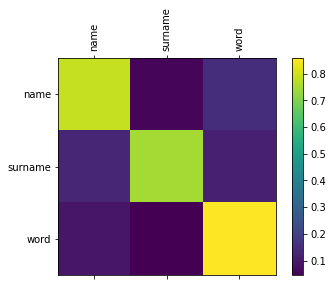

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(line_to_tensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('алмат')
predict('стол')
predict('абаев')


> алмат
(-0.05) name
(-3.02) word
(-5.74) surname

> стол
(-0.28) word
(-1.40) name
(-6.31) surname

> абаев
(-0.46) surname
(-1.00) name
(-5.70) word


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
